# Structural EDA of Ubuntu Dialogue corpus

In [1]:
# load data
import pyarrow.dataset as ds

folder_path = "../data/processed/convo/dialogues_parquet/"

dataset = ds.dataset(folder_path, format="parquet")

In [2]:
# schema inspection
dataset.schema

folder: string
dialogueID: string
date: timestamp[ns, tz=UTC]
sender: string
to: string
text: string
id: string
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 887

In [3]:
# row count
scanner = dataset.scanner(columns=["dialogueID"])
total_rows = sum(batch.num_rows for batch in scanner.to_batches())
total_rows

14921650

In [4]:
# dialogue cardinality
import pyarrow.compute as pc

dialogues = dataset.to_table(columns=["dialogueID"])
unique_dialogues = pc.count_distinct(dialogues["dialogueID"])
unique_dialogues

<pyarrow.Int64Scalar: 346108>

In [5]:
# speaker balance and turn counts
table = dataset.to_table(columns=["sender"])
speaker_counts = table.group_by("sender").aggregate([("sender", "count")])
speaker_counts.to_pandas()

,sender,sender_count
0,Lehthanis,28
1,IzcRaZY,11
2,XrekcaH,44
3,jonas-irc,33
4,bunny,58
...,...,...
317961,shoen,11
317962,ScottKevill,14
317963,arthursc,1
317964,jddog,13


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

speaker_counts_df = speaker_counts.to_pandas()  
print(speaker_counts_df.head())
print(speaker_counts_df.dtypes)

      sender  sender_count
0  Lehthanis            28
1    IzcRaZY            11
2    XrekcaH            44
3  jonas-irc            33
4      bunny            58
sender          object
sender_count     int64
dtype: object


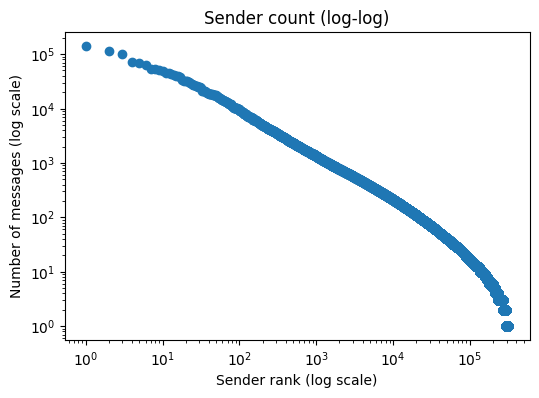

In [18]:
df = speaker_counts_df.dropna(subset=['sender','sender_count']).copy()
df['sender_count'] = pd.to_numeric(df['sender_count'], errors='coerce')
df = df.dropna(subset=['sender_count']).sort_values('sender_count', ascending=False).reset_index(drop=True)

x = np.arange(1, len(df)+1)   # sender rank
y = df['sender_count'].astype(float).values

plt.figure(figsize=(6,4))
plt.loglog(x, y, marker='o', linestyle='none')
plt.xlabel('Sender rank (log scale)')
plt.ylabel('Number of messages (log scale)')
plt.title('Sender count (log-log)')
plt.show()

In [ ]:
# missing values check
missing_values = {}
for name in dataset.schema.names:
    null_count = 0

    # Stream the dataset in record batches, only reading this column
    for batch in dataset.to_batches(columns=[name]):
        col = batch.column(0)  # only one column selected
        null_count += pc.count(col, mode="only_null").as_py()

    missing_values[name] = null_count

missing_values

{'folder': 0,
 'dialogueID': 0,
 'date': 0,
 'sender': 502,
 'to': 3411720,
 'text': 1363,
 'id': 0}

In [6]:
# messages per dialogue
dialogue_table = dataset.to_table(columns=["dialogueID"])
turn_counts = dialogue_table.group_by("dialogueID").aggregate([("dialogueID", "count")])
turn_counts.to_pandas()

,dialogueID,dialogueID_count
0,251529,8
1,140168,20
2,276048,6
3,9692,224
4,121195,28
...,...,...
346103,303783,3
346104,328297,6
346105,208436,15
346106,81206,41


In [7]:
# message length statistics
import pyarrow.compute as pc

message_table = dataset.to_table(columns=["text"])
message_lengths = pc.utf8_length(message_table["text"])
length_stats = {
    "min": pc.min(message_lengths).as_py(),
    "max": pc.max(message_lengths).as_py(),
    "mean": pc.mean(message_lengths).as_py(),
    "stddev": pc.stddev(message_lengths).as_py(),
}
length_stats

{'min': 1,
 'max': 18165,
 'mean': 98.06991192595692,
 'stddev': 114.84684301469979}

In [8]:
# folder numbers per source file
file_table = dataset.to_table(columns=["folder"])
file_counts = file_table.group_by("folder").aggregate([("folder", "count")])
file_counts.to_pandas()

,folder,folder_count
0,3,2331105
1,20,276296
2,242,1940
3,36,98168
4,225,820
...,...,...
344,274,372
345,83,8394
346,393,268
347,167,425


In [9]:
# missing values check
missing_values = {}
for name in dataset.schema.names:
    null_count = 0

    # Stream the dataset in record batches, only reading this column
    for batch in dataset.to_batches(columns=[name]):
        col = batch.column(0)  # only one column selected
        null_count += pc.count(col, mode="only_null").as_py()

    missing_values[name] = null_count

missing_values

{'folder': 0,
 'dialogueID': 0,
 'date': 0,
 'sender': 502,
 'to': 3411720,
 'text': 1363,
 'id': 0}

In [10]:
len(missing_values)

7

In [11]:
print(missing_values)

{'folder': 0, 'dialogueID': 0, 'date': 0, 'sender': 502, 'to': 3411720, 'text': 1363, 'id': 0}


In [ ]:
# turn taking balances (messages per speaker per dialogue)